Open a new terminal and run the following commands to install the prerequisites for ns-3

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


Extract the packages to be installed...

In [2]:
packages_file = open('packages.txt', 'r')
packages = packages_file.read().split()

#### Configure the VM

In [3]:
slice_name="hpc-" + fablib.get_bastion_username()

#### Reserve Resources

In [4]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


In [30]:
site_name = fablib.get_random_site()
fablib.show_site(site_name)

Name,FIU
State,Active
Address,"11001 SW 14th St,Miami,FL 33199"
Location,"(0, 0)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,408
Cores Capacity,640
Cores Allocated,232
RAM Available,1206


'<pandas.io.formats.style.Styler object at 0x7d3712690a90>'

In [34]:
slice.add_node(name='hpc', site=site_name, 
                   cores=64, 
                   ram=256, 
                   disk=100, 
                   image='default_ubuntu_22')

In [35]:
slice.submit()


Retry: 6, Time: 166 sec


ID,c51c557f-bf4f-4d5b-b8c7-0ec0e17b7a50
Name,hpc-nm3833_0000195331
Lease Expiration (UTC),2024-06-26 18:11:03 +0000
Lease Start (UTC),2024-06-25 18:11:05 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
f13df969-12ad-4291-8f72-810537f0db31,hpc,64,384,1000,default_ubuntu_22,qcow2,fiu-w3.fabric-testbed.net,FIU,ubuntu,131.94.57.41,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.41,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


'c51c557f-bf4f-4d5b-b8c7-0ec0e17b7a50'

In [36]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

#### Configure Resources

In [37]:
slice = fablib.get_slice(name=slice_name)

The following line executes in the background

In [38]:
node = slice.get_node('hpc')
pkg = " ".join(packages)
node.execute_thread("sudo apt update; sudo DEBIAN_FRONTEND=noninteractive apt -y install %s" % pkg)

<Future at 0x7d36f056f750 state=running>

SSH Command for the VM node

In [5]:
import pandas as pd
node = slice.get_node('hpc')
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': node.get_name(), 'SSH command': node.get_ssh_command()}]
print(pd.DataFrame(slice_info).set_index('Name').iloc[0,0])

ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.41


#### Extending Slice Expiration

In [6]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta
# Set end date to 3 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

In [7]:
slice.update()
_ = slice.show()

ID,c51c557f-bf4f-4d5b-b8c7-0ec0e17b7a50
Name,hpc-nm3833_0000195331
Lease Expiration (UTC),2024-07-04 00:28:30 +0000
Lease Start (UTC),2024-06-25 18:11:05 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


#### Installing NS3

Open the terminal and SSH into Romeo using the SSH command generated during the resource congifuration step.

Run the following commands.
```bash
$  git clone https://gitlab.com/nsnam/bake
$  export BAKE_HOME=`pwd`/bake 
$  export PATH=$PATH:$BAKE_HOME
$  export PYTHONPATH=$PYTHONPATH:$BAKE_HOME
```

```bash
$  bake.py check
$  bake.py configure -e ns-3.42
```

Use the following command to check if there are any missing dependencies and install them manually.
```bash
$  bake.py show
```

Finally
```bash
$  bake.py deploy
```

Configure Environmental Variables
```bash
$  export NS3_HOME=`pwd`
$  export PATH=$PATH:$NS3_HOME
```

```bash
ns3 configure --build-profile=debug
```

#### Simulating TCP congestion control

In [6]:
import os

In [6]:
hbc = slice.get_node("hpc")
thread = hbc.execute_thread("mkdir ~/source/ns-3.42/scratch/TCP-ns3/tcp-bbr-replication-experiment")
print(thread.result())

local_file_path = os.path.join(os.getcwd(), "tcp-bbr-replication.cc")

if not os.path.exists(local_file_path):
    raise FileNotFoundError(f"The file {local_file_path} does not exist.")

remote_file_path = "source/ns-3.42/scratch/tcp-bbr-replication-experiment/tcp-bbr-replication.cc"
hbc.upload_file(local_file_path, remote_file_path)

('', 'mkdir: cannot create directory ‘/home/ubuntu/source/ns-3.42/scratch/tcp-congestion-control’: File exists\n')


<SFTPAttributes: [ size=18006 uid=1000 gid=1000 mode=0o100664 atime=1718573012 mtime=1718586872 ]>

In [ ]:
hpc.upload_file('parameters.csv', "source/ns-3.42/parameters.csv")

In [ ]:
hpc.upload_file('simulate.sh', "source/ns-3.42/simulate.sh")
hpc.execute("chmod +x source/ns-3.42/simulate.sh")

```bash
$  cd source/ns-3.42
$  ./ns3 build
$  ./ns3 run "scratch/tcp-brr-replication-experiment/tcp-bbr-replication.cc --qdiscSize=100kB --bottleneck_bandwidth=500Mbps --delay=18.75ms --tcpTypeId=ns3::TcpCubic"
```

This will run the TCP congestion control sumulation and generate the a file containing the changes in cwnd and sstresh as the simulation progresses.

#### Visulaization

Run the following line to download the result data. You should see a success message.

In [177]:
hpc = slice.get_node("hpc")
result = hpc.download_directory(os.getcwd(), "simulation_data")
print(result)

success


In [178]:
#!pip install seaborn

In [179]:
import pandas as pd
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import itertools
import os
import re

In [180]:
# Assuming 'path_to_results' is the path to the 'tcp-bbr-cubic-results' directory
path_to_results = "simulation_data"
results = []

# List all directories within the results directory
directories = [d for d in os.listdir(path_to_results) if os.path.isdir(os.path.join(path_to_results, d))]

# Parse each directory name to extract the fields
for directory in directories:
    parts = directory.split('_')
    if len(parts) == 4:  # Ensure the directory name contains all expected parts
        qdiscSize = parts[0]  # e.g., 100kB
        bottleneck_bandwidth = parts[1]    # e.g., 250Mbps
        delay = parts[2]      # e.g., 50.0ms
        tcpTypeId = parts[3]  # e.g., TcpBbr

        # print(f"Packet size: {qdiscSize}, bottleneck_bandwidth: {bottleneck_bandwidth}, Latency: {delay}, TCP algorithm: {tcpTypeId}")
        
        goodput_retransmission_path = os.path.join(path_to_results, directory, "goodput_retransmission_results.txt")
        if os.path.exists(goodput_retransmission_path):
            with open(goodput_retransmission_path, 'r') as file:
                goodput_retransmission_data = file.read()
            
            queue_size_path = os.path.join(path_to_results, directory, "queue-size.dat")
            # Regular expression patterns to find throughput and retransmissions
            throughput_pattern = r"Throughput: (\d+\.\d+) Mbps"
            retransmissions_pattern = r"Retransmissions: (\d+)"
            average_delay_pattern = r"Average Delay: (\d+\.\d+)"

            # Searching for throughput
            throughput_match = re.search(throughput_pattern, goodput_retransmission_data)
            throughput = throughput_match.group(1)
            # print(f"Throughput: {throughput} Mbps")
            
            # Searching for retransmissions
            retransmissions_match = re.search(retransmissions_pattern, goodput_retransmission_data)
            retransmissions = retransmissions_match.group(1)
            # print(f"Retransmissions: {retransmissions}")
            
            # Searching for average delay
            average_delay_match = re.search(average_delay_pattern, goodput_retransmission_data)
            if average_delay_match:
                average_delay = average_delay_match.group(1)
            else:
                average_delay=None
            # print(f"Average Delay: {average_delay} ms")
            
            df = pd.read_csv((queue_size_path), sep='\s+', header=None, names=['Time', 'Value'])
            average = df['Value'].mean()
            # print(f"Average queue-size: {average:.2f}")

            results.append({
                'qdiscSize': qdiscSize,
                'bottleneck_bandwidth': bottleneck_bandwidth,
                'delay': delay,
                'tcpTypeId': tcpTypeId,
                'goodput': throughput,
                'retransmissions': retransmissions,
                'average_queue_size': average,
                'latency':average_delay
            })


In [181]:
df_result = pd.DataFrame(results)
df_result['delay'] = df_result.loc[:,'delay'].str.replace('ms','').astype(float)*4
df_result['delay'] = df_result.loc[:,'delay']
df_result['qdiscSize'] = df_result.loc[:,'qdiscSize'].str.replace('MB','').str.replace('kB','').astype(float)
df_result['bottleneck_bandwidth'] = df_result.loc[:,'bottleneck_bandwidth'].str.replace('Mbps','').astype(float)
df_result = df_result[(df_result['delay'] != 20) & (df_result['bottleneck_bandwidth'] != 1000) ]
df_result.head()

,qdiscSize,bottleneck_bandwidth,delay,tcpTypeId,goodput,retransmissions,average_queue_size,latency
0,10.0,20.0,100.0,TcpBbr,18.0998,85,19916.350,0.0595686
1,100.0,50.0,5.0,TcpBbr,45.9917,34,30367.350,0.00802837
2,10.0,250.0,200.0,TcpCubic,226.772,8324,7315559.100,0.345193
3,10.0,50.0,150.0,TcpBbr,45.3898,311,80043.225,0.0887866
4,100.0,50.0,50.0,TcpCubic,45.7623,152,48588.250,0.0335654


In [182]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
# force it to drop bad runs
# df_tput = df_tput.drop(columns=['ret'])
exp_factors = { 
    'qdiscSize': ["100kB", "10MB"],
    'bottleneck_bandwidth': ["10Mbps", "20Mbps", "50Mbps", "100Mbps", "250Mbps", "500Mbps", "750Mbps", "1000Mbps"],
    'delay': [i for i in [200, 10, 25, 50, 75, 100, 150, 5]],
    'tcpTypeId': ["TcpCubic", "TcpBbr"],
    'trial': [1]
}
factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(goodput_gain = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][1]]-df_tput['goodput' + exp_factors['tcpTypeId'][0]])/df_tput['goodput' + exp_factors['tcpTypeId'][0]])

In [183]:
df_tput[df_tput['bottleneck_bandwidth']==1000.0]

,qdiscSize,bottleneck_bandwidth,delay,goodputTcpBbr,goodputTcpCubic,goodput_gain


In [184]:
kernel = 'ns3'

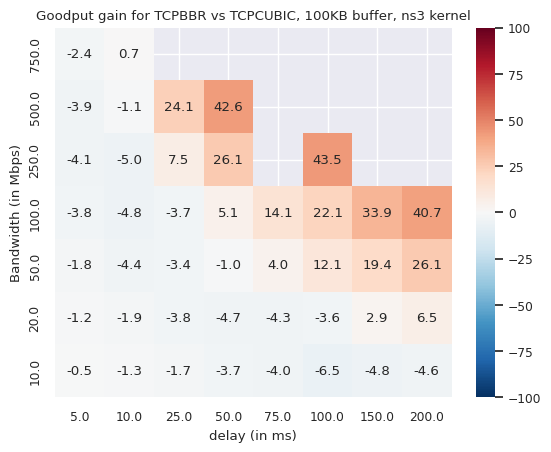

In [185]:
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['tcpTypeId'][1].upper() + " vs " + exp_factors['tcpTypeId'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

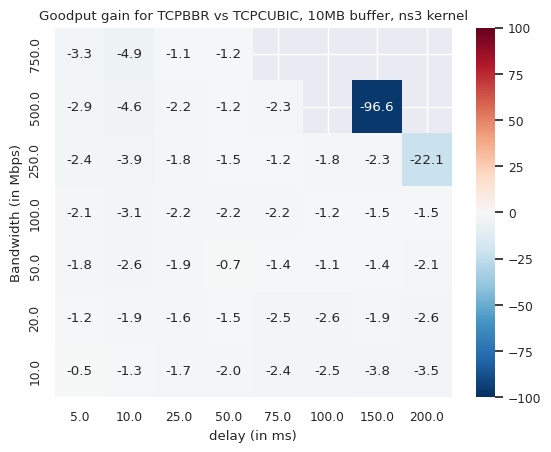

In [186]:
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['tcpTypeId'][1].upper() + " vs " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

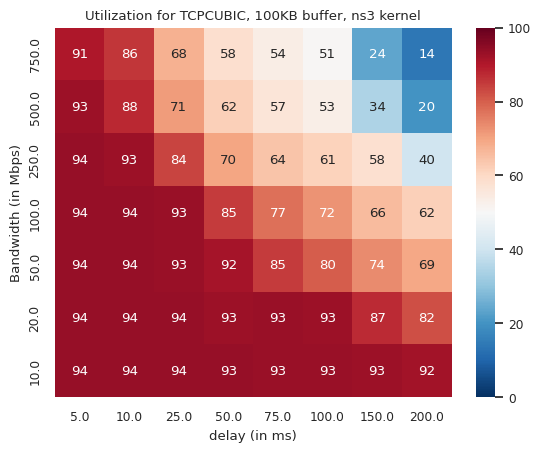

In [187]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][0] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [ ]:
df = df_tput[(df_tput['bottleneck_bandwidth'] == 1000.0) & (df_tput['qdiscSize']==100)].loc[:,:].drop(columns=['goodputTcpBbr','goodputTcpCubic','goodput_gain'])
for i in df.index:
    l=list(df.loc[i,:].values)
    l[0] = str(int(l[0]))+'kB'
    l[1]=str(int(l[1]))+'Mbps'
    l[2] = str(l[2])+'ms'
    l.append('TcpCubic')
    l.append('1')
    print(','.join(l))

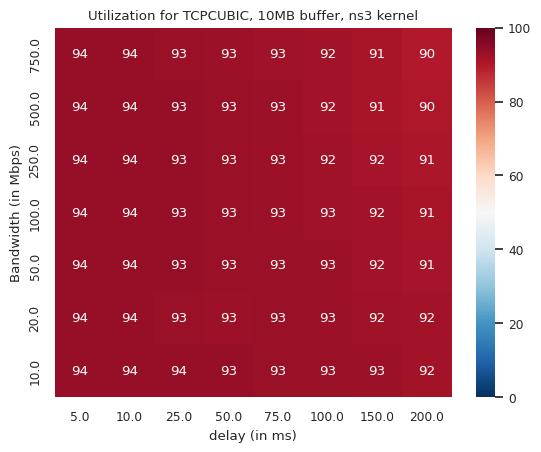

In [189]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][0] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

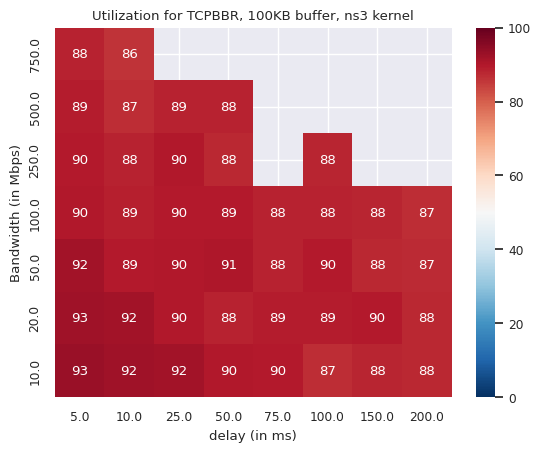

In [190]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][1] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][1].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

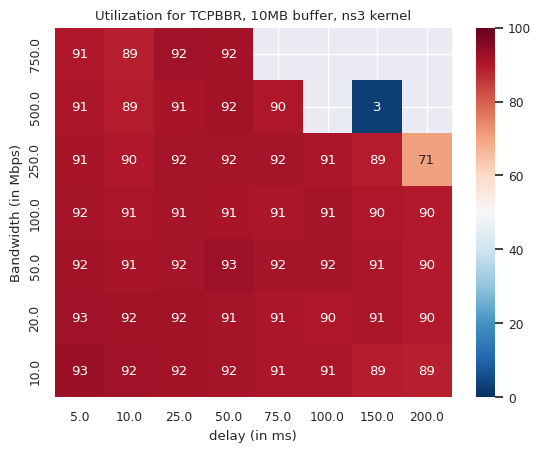

In [191]:
df_tput = df_result.drop(columns=['retransmissions','average_queue_size','latency'])
df_tput['goodput'] = pd.to_numeric(df_tput['goodput'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['goodput'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput' + exp_factors['tcpTypeId'][1] ]/(df_tput['bottleneck_bandwidth'])))
dat_hm = df_tput[df_tput.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [192]:
df_retx = df_result.drop(columns=['average_queue_size','latency','goodput'])
df_retx = df_retx.fillna(0)
df_retx['retransmissions'] = df_retx.loc[:,'retransmissions'].astype(float)
# df_retx.head()
df_retx = df_retx.pivot_table(columns='tcpTypeId', index=['qdiscSize','bottleneck_bandwidth','delay'], values=['retransmissions'], aggfunc='mean').reset_index() 
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx.head()

,qdiscSize,bottleneck_bandwidth,delay,retransmissionsTcpBbr,retransmissionsTcpCubic
0,10.0,10.0,5.0,12.0,6216.0
1,10.0,10.0,10.0,20.0,6242.0
2,10.0,10.0,25.0,35.0,6324.0
3,10.0,10.0,50.0,57.0,5015.0
4,10.0,10.0,75.0,54.0,6683.0


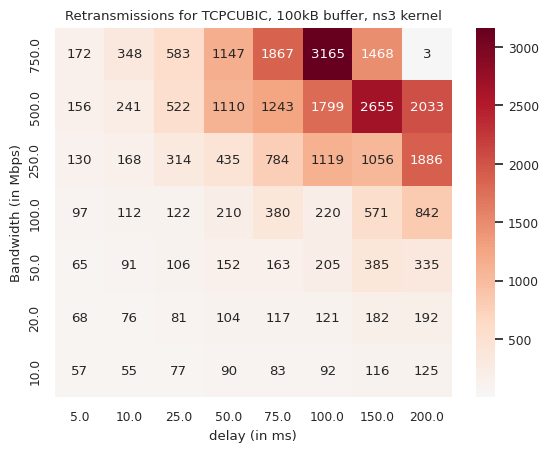

In [193]:
dat_hm = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['tcpTypeId'][0].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

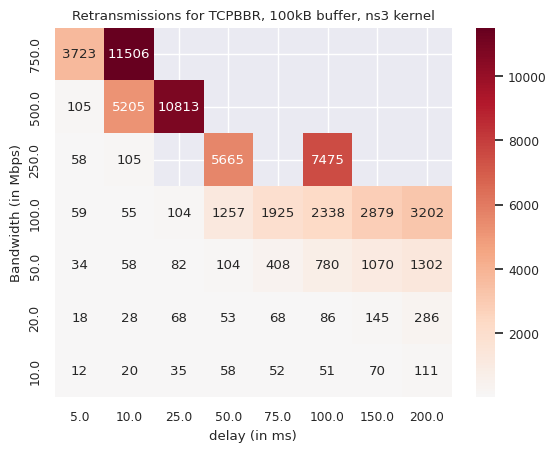

In [176]:
dat_hm = df_retx[df_retx.qdiscSize==100].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['tcpTypeId'][1].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

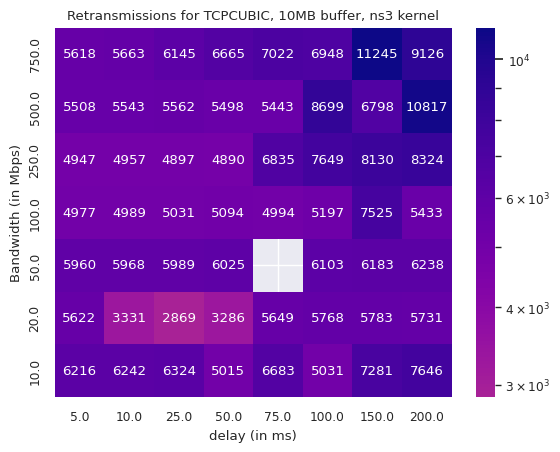

In [172]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="plasma_r",norm=LogNorm(), center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['tcpTypeId'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

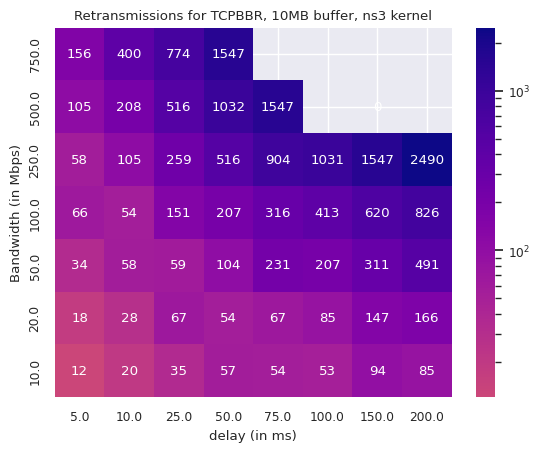

In [173]:
dat_hm = df_retx[df_retx.qdiscSize==10].pivot(index=["bottleneck_bandwidth"], columns=["delay"], values="retransmissions"+exp_factors['tcpTypeId'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="plasma_r", norm=LogNorm(), center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['tcpTypeId'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("delay (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

<h4 style="color:red;">To delete the slice</h4>

In [22]:
slice = fablib.get_slice(name=slice_name)
fablib.delete_slice(slice_name)

In [23]:
slice.update()
_ = slice.show()

ID,10948f08-483f-45b3-9ebd-de1b60c039bf
Name,tcp_congestion_control_ns3-nm3833_0000195331
Lease Expiration (UTC),2024-06-26 16:40:16 +0000
Lease Start (UTC),2024-06-25 16:40:17 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK
